In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall dlib


Found existing installation: dlib 19.24.2
Uninstalling dlib-19.24.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/_dlib_pybind11.cpython-311-x86_64-linux-gnu.so
    /usr/local/lib/python3.11/dist-packages/dlib-19.24.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/dlib/*
Proceed (Y/n)? Y
  Successfully uninstalled dlib-19.24.2


In [ ]:
!pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp311-cp311-linux_x86_64.whl size=4490664 sha256=d8c0a17134b03e59d4df9da68a09473514517facc4a588e4940a8567dc8f3a44
  Stored in directory: /root/.cache/pip/wheels/fe/c7/1f/c778b9f7cc6d8d0da4f6697f619f9eb5a49d54d2a2c8267f3c
Successfully built dlib


In [ ]:
!pip install mediapipe --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompati

In [ ]:
!pip install dlib

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow

def get_face_pose(image_path):
    """
    Get face pose using MediaPipe Face Mesh (CNN-based approach)
    Returns head pose angles in degrees (yaw, pitch, roll)
    """
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )

    # Read image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect face landmarks
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        print("No face detected!")
        return None

    face_landmarks = results.multi_face_landmarks[0]

    # Get important facial landmarks
    # MediaPipe uses different indices than dlib
    nose_tip = face_landmarks.landmark[1]    # Nose tip
    chin = face_landmarks.landmark[152]      # Chin
    left_eye = face_landmarks.landmark[33]   # Left eye corner
    right_eye = face_landmarks.landmark[263] # Right eye corner
    left_mouth = face_landmarks.landmark[61] # Left mouth corner
    right_mouth = face_landmarks.landmark[291] # Right mouth corner

    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]

    # 3D model points - adjusted for MediaPipe landmarks with more realistic face proportions
    model_points = np.array([
        (0.0, 0.0, 0.0),            # Nose tip
        (0.0, -75.0, -30.0),        # Chin
        (-65.0, 35.0, -50.0),       # Left eye corner
        (65.0, 35.0, -50.0),        # Right eye corner
        (-45.0, -50.0, -50.0),      # Left mouth corner
        (45.0, -50.0, -50.0)        # Right mouth corner
    ])

    # 2D points in image plane
    image_points = np.array([
        (nose_tip.x * width, nose_tip.y * height),
        (chin.x * width, chin.y * height),
        (left_eye.x * width, left_eye.y * height),
        (right_eye.x * width, right_eye.y * height),
        (left_mouth.x * width, left_mouth.y * height),
        (right_mouth.x * width, right_mouth.y * height)
    ], dtype="double")

    # Camera matrix estimation
    focal_length = width
    center = (width/2, height/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    dist_coeffs = np.zeros((4,1))

    # Solve PnP
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs)

    # Convert rotation vector to Euler angles
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    pose_matrix = cv2.hconcat((rotation_matrix, translation_vector))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_matrix)

    # Get angles and normalize them
    yaw = euler_angles[1][0]    # Left/Right head rotation
    pitch = euler_angles[0][0]  # Up/Down head rotation
    roll = euler_angles[2][0]   # Head tilt left/right

    # Normalize angles to ensure they're in the expected range
    if pitch > 90:
        pitch = 180 - pitch
    elif pitch < -90:
        pitch = -180 - pitch

    if roll > 90:
        roll = 180 - roll
    elif roll < -90:
        roll = -180 - roll

    print(f"Head pose angles:")
    print(f"Yaw: {yaw:.2f}°")    # Negative: looking left, Positive: looking right
    print(f"Pitch: {pitch:.2f}°") # Negative: looking up, Positive: looking down
    print(f"Roll: {roll:.2f}°")   # Negative: tilting left, Positive: tilting right

    # Draw landmarks on image for visualization
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    # Draw the face mesh
    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
    )

    # Display image with landmarks using Colab's cv2_imshow
    cv2_imshow(image)

    face_mesh.close()
    return yaw, pitch, roll

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Head pose angles:
Yaw: 47.96°
Pitch: -7.41°
Roll: 0.66°


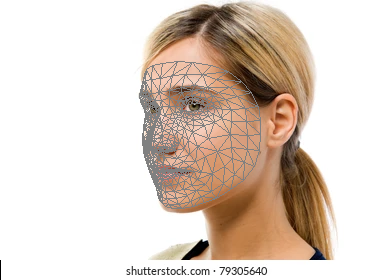

In [ ]:

if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/SOP_Data/left-face.webp'  # Replace with your image path
    get_face_pose(image_path)

Head pose angles:
Yaw: 0.44°
Pitch: -18.09°
Roll: 0.06°


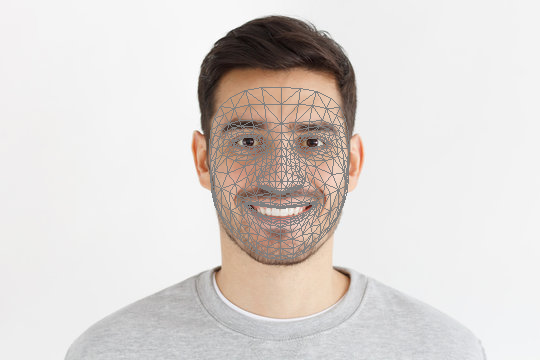

(0.4379543811539334, -18.092266654699102, 0.0642667478779178)

In [ ]:
get_face_pose("/content/drive/MyDrive/SOP_Data/tes1.jpg")

Head pose angles:
Yaw: 29.07°
Pitch: -12.26°
Roll: -5.25°


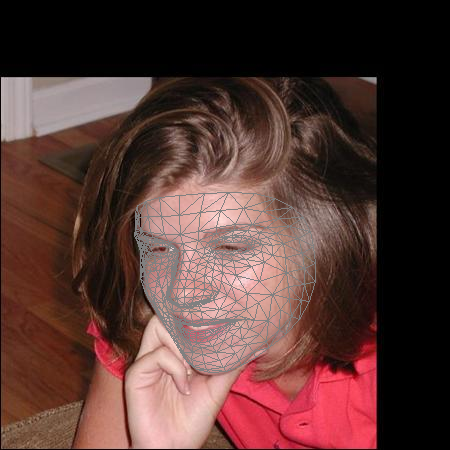

(29.073572866450554, -12.261638052927253, -5.249927655701834)

In [ ]:
get_face_pose("/content/drive/MyDrive/SOP_Data/AFW_134212_1_0_-0.318_0.469_-0.150.jpg")

Head pose angles:
Yaw: 26.55°
Pitch: -17.58°
Roll: -2.61°


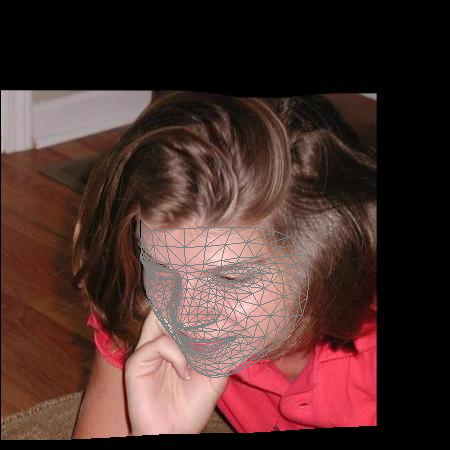

(26.546228253906513, -17.578194542146974, -2.6144025682342247)

In [ ]:
get_face_pose("/content/drive/MyDrive/SOP_Data/AFW_134212_1_0_-0.754_0.469_-0.150.jpg")

Head pose angles:
Yaw: 49.48°
Pitch: -10.54°
Roll: 7.32°


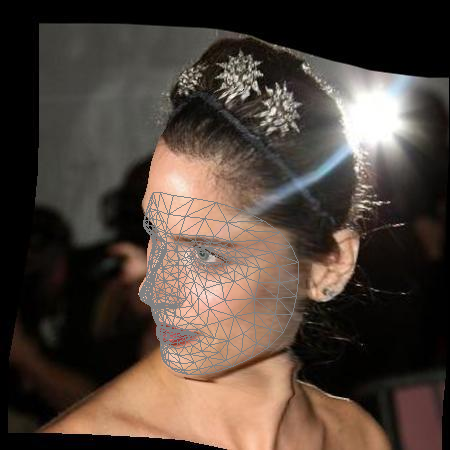

(49.475331199957395, -10.536166187132352, 7.318337489807841)

In [ ]:
get_face_pose("/content/drive/MyDrive/SOP_Data/LFPW_image_train_0003_8_-0.489_0.935_-0.062.jpg")

In [ ]:
import dlib
dlib.DLIB_USE_CUDA = False
detector = dlib.cnn_face_detection_model_v1("/content/drive/MyDrive/SOP_Data/mmod_human_face_detector.dat")  # CNN model
 # This ensures Dlib won't attempt GPU processing
predictor = dlib.shape_predictor("/content/drive/MyDrive/SOP_Data/shape_predictor_68_face_landmarks.dat")  # 68-landmark mode

In [ ]:
import cv2
#import mediapipe as mp
import numpy as np
import dlib
from google.colab.patches import cv2_imshow

def get_face_pose_68(image_path):
    """
    Get face pose using dlib's CNN face detector and 68 facial landmarks
    Returns head pose angles in degrees (yaw, pitch, roll)
    """
    # Initialize the CNN detector and landmark predictor
    cnn_face_detector = dlib.cnn_face_detection_model_v1("/content/drive/MyDrive/SOP_Data/mmod_human_face_detector.dat")
    landmark_predictor = dlib.shape_predictor("/content/drive/MyDrive/SOP_Data/shape_predictor_68_face_landmarks.dat")

    # Read image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using CNN detector
    faces = cnn_face_detector(gray, 1)  # 1 means upsample once for better detection

    if len(faces) == 0:
        print("No face detected!")
        return None

    # Get landmarks for the first face
    face = faces[0].rect
    landmarks = landmark_predictor(gray, face)

    # Get specific facial landmarks
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)     # Nose tip
    chin = (landmarks.part(8).x, landmarks.part(8).y)           # Chin
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)     # Left eye left corner
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)    # Right eye right corner
    left_mouth = (landmarks.part(48).x, landmarks.part(48).y)   # Left mouth corner
    right_mouth = (landmarks.part(54).x, landmarks.part(54).y)  # Right mouth corner

    # Convert to numpy array
    image_points = np.array([
        nose_tip,      # Nose tip
        chin,          # Chin
        left_eye,      # Left eye left corner
        right_eye,     # Right eye right corner
        left_mouth,    # Left mouth corner
        right_mouth    # Right mouth corner
    ], dtype="double")

    # 3D model points - adjusted for better angle accuracy
    model_points = np.array([
        (0.0, 0.0, 0.0),            # Nose tip
        (0.0, -75.0, -30.0),        # Chin
        (-65.0, 35.0, -50.0),       # Left eye corner
        (65.0, 35.0, -50.0),        # Right eye corner
        (-45.0, -50.0, -50.0),      # Left mouth corner
        (45.0, -50.0, -50.0)        # Right mouth corner
    ])

    # Camera matrix estimation
    height, width = image.shape[:2]
    focal_length = width
    center = (width/2, height/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    dist_coeffs = np.zeros((4,1))

    # Solve PnP
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs)

    # Convert rotation vector to Euler angles
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    pose_matrix = cv2.hconcat((rotation_matrix, translation_vector))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_matrix)

    # Get angles and normalize them
    yaw = euler_angles[1][0]    # Left/Right head rotation
    pitch = euler_angles[0][0]  # Up/Down head rotation
    roll = euler_angles[2][0]   # Head tilt left/right

    # Normalize angles to ensure they're in the expected range
    if pitch > 90:
        pitch = 180 - pitch
    elif pitch < -90:
        pitch = -180 - pitch

    if roll > 90:
        roll = 180 - roll
    elif roll < -90:
        roll = -180 - roll

    print(f"Head pose angles:")
    print(f"Yaw: {yaw:.2f}°")    # Negative: looking left, Positive: looking right
    print(f"Pitch: {pitch:.2f}°") # Negative: looking up, Positive: looking down
    print(f"Roll: {roll:.2f}°")   # Negative: tilting left, Positive: tilting right

    # Draw landmarks on image for visualization
    for i in range(68):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

    # Display image with landmarks using Colab's cv2_imshow
    cv2_imshow(image)

    return yaw, pitch, roll



use the below one error in the above

In [ ]:
import cv2
import numpy as np
import dlib
from google.colab.patches import cv2_imshow

def get_face_pose_68(image_path):
    """
    Get face pose using dlib's CNN face detector and 68 facial landmarks
    Returns head pose angles in degrees (yaw, pitch, roll)
    """
    # Initialize the CNN detector and landmark predictor
    cnn_face_detector = dlib.get_frontal_face_detector()
    landmark_predictor = dlib.shape_predictor("/content/drive/MyDrive/SOP_Data/shape_predictor_68_face_landmarks.dat")

    # Read image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using CNN detector
    faces = cnn_face_detector(gray, 1)  # 1 means upsample once for better detection

    if len(faces) == 0:
        print("No face detected!")
        return None

    # Get landmarks for the first face
    face = faces[0]  # Directly use the rectangle object
    landmarks = landmark_predictor(gray, face)

    # Get specific facial landmarks
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)     # Nose tip
    chin = (landmarks.part(8).x, landmarks.part(8).y)           # Chin
    left_eye = (landmarks.part(36).x, landmarks.part(36).y)     # Left eye left corner
    right_eye = (landmarks.part(45).x, landmarks.part(45).y)    # Right eye right corner
    left_mouth = (landmarks.part(48).x, landmarks.part(48).y)   # Left mouth corner
    right_mouth = (landmarks.part(54).x, landmarks.part(54).y)  # Right mouth corner

    # Convert to numpy array
    image_points = np.array([
        nose_tip,      # Nose tip
        chin,          # Chin
        left_eye,      # Left eye left corner
        right_eye,     # Right eye right corner
        left_mouth,    # Left mouth corner
        right_mouth    # Right mouth corner
    ], dtype="double")

    # 3D model points - adjusted for better angle accuracy
    model_points = np.array([
        (0.0, 0.0, 0.0),            # Nose tip
        (0.0, -75.0, -30.0),        # Chin
        (-65.0, 35.0, -50.0),       # Left eye corner
        (65.0, 35.0, -50.0),        # Right eye corner
        (-45.0, -50.0, -50.0),      # Left mouth corner
        (45.0, -50.0, -50.0)        # Right mouth corner
    ])

    # Camera matrix estimation
    height, width = image.shape[:2]
    focal_length = width
    center = (width/2, height/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    dist_coeffs = np.zeros((4,1))

    # Solve PnP
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs)

    # Convert rotation vector to Euler angles
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    pose_matrix = cv2.hconcat((rotation_matrix, translation_vector))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_matrix)

    # Get angles and normalize them
    yaw = euler_angles[1][0]    # Left/Right head rotation
    pitch = euler_angles[0][0]  # Up/Down head rotation
    roll = euler_angles[2][0]   # Head tilt left/right

    # Normalize angles to ensure they're in the expected range
    if pitch > 90:
        pitch = 180 - pitch
    elif pitch < -90:
        pitch = -180 - pitch

    if roll > 90:
        roll = 180 - roll
    elif roll < -90:
        roll = -180 - roll

    print(f"Head pose angles:")
    print(f"Yaw: {yaw:.2f}°")    # Negative: looking left, Positive: looking right
    print(f"Pitch: {pitch:.2f}°") # Negative: looking up, Positive: looking down
    print(f"Roll: {roll:.2f}°")   # Negative: tilting left, Positive: tilting right

    # Draw landmarks on image for visualization
    for i in range(68):
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

    # Display image with landmarks using Colab's cv2_imshow
    cv2_imshow(image)

    return yaw, pitch, roll



Head pose angles:
Yaw: 60.00°
Pitch: -3.04°
Roll: 1.27°


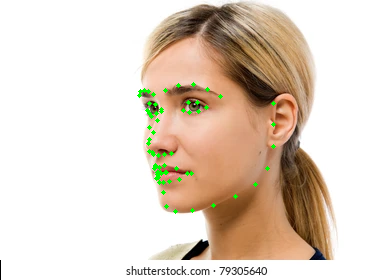

In [ ]:
if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/SOP_Data/left-face.webp'  # Your image path
    get_face_pose_68(image_path)

Head pose angles:
Yaw: -1.53°
Pitch: -14.27°
Roll: -0.64°


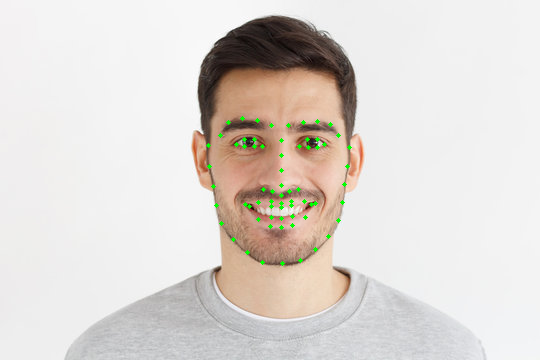

(np.float64(-1.5348994158862674),
 np.float64(-14.267927889671029),
 np.float64(-0.6368069290795946))

In [ ]:
get_face_pose_68("/content/drive/MyDrive/SOP_Data/tes1.jpg")

In [ ]:
get_face_pose_68("/content/drive/MyDrive/SOP_Data/looking_up.jpg")

No face detected!


Head pose angles:
Yaw: -0.51°
Pitch: 16.71°
Roll: -17.33°


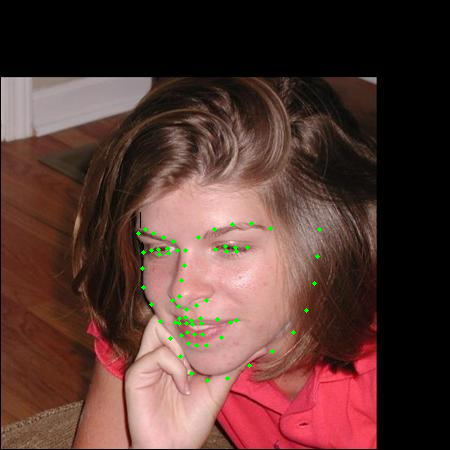

(np.float64(-0.5127261774594178),
 np.float64(16.70867997794099),
 np.float64(-17.32964305026744))

In [ ]:
get_face_pose_68("/content/drive/MyDrive/SOP_Data/AFW_134212_1_0_-0.318_0.469_-0.150.jpg")

In [ ]:
get_face_pose("/content/drive/MyDrive/SOP_Data/looking_up.jpg")

NameError: name 'get_face_pose' is not defined

Click on the button to capture frame


<IPython.core.display.Javascript object>

Head pose angles:
Yaw: -49.6° (Left/Right)
Pitch: 3.1° (Up/Down)
Roll: -1.0° (Tilt)


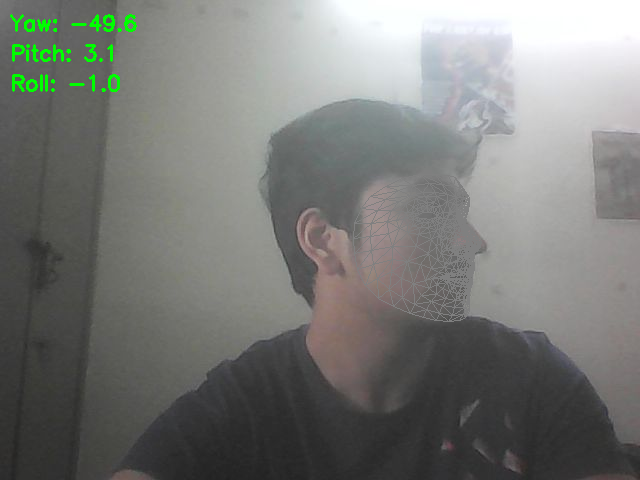

Press Enter to continue or 'q' to quit: q


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

def js_to_image(js_reply):
    """
    Convert JS webcam output to OpenCV image
    """
    # decode base64 image
    image_bytes = b64decode(js_reply.split(',')[1])
    # convert bytes to numpy array
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    # decode numpy array into image
    image = cv2.imdecode(jpg_as_np, flags=1)
    return image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = "Take Photo";
            capture.style.marginBottom = '10px';
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(capture);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => {
                capture.onclick = resolve;
            });

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return data

def process_face_pose(frame):
    """
    Process a single frame and return head pose angles
    """
    # Initialize MediaPipe Face Mesh
    with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:

        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect face landmarks
        results = face_mesh.process(frame_rgb)

        if not results.multi_face_landmarks:
            return None, frame

        face_landmarks = results.multi_face_landmarks[0]

        # Get important facial landmarks
        nose_tip = face_landmarks.landmark[1]
        chin = face_landmarks.landmark[152]
        left_eye = face_landmarks.landmark[33]
        right_eye = face_landmarks.landmark[263]
        left_mouth = face_landmarks.landmark[61]
        right_mouth = face_landmarks.landmark[291]

        # Get image dimensions
        height, width = frame.shape[:2]

        # 3D model points
        model_points = np.array([
            (0.0, 0.0, 0.0),
            (0.0, -75.0, -30.0),
            (-65.0, 35.0, -50.0),
            (65.0, 35.0, -50.0),
            (-45.0, -50.0, -50.0),
            (45.0, -50.0, -50.0)
        ])

        # 2D points in image plane
        image_points = np.array([
            (nose_tip.x * width, nose_tip.y * height),
            (chin.x * width, chin.y * height),
            (left_eye.x * width, left_eye.y * height),
            (right_eye.x * width, right_eye.y * height),
            (left_mouth.x * width, left_mouth.y * height),
            (right_mouth.x * width, right_mouth.y * height)
        ], dtype="double")

        # Camera matrix estimation
        focal_length = width
        center = (width/2, height/2)
        camera_matrix = np.array(
            [[focal_length, 0, center[0]],
             [0, focal_length, center[1]],
             [0, 0, 1]], dtype="double"
        )

        dist_coeffs = np.zeros((4,1))

        # Solve PnP
        success, rotation_vector, translation_vector = cv2.solvePnP(
            model_points, image_points, camera_matrix, dist_coeffs)

        # Convert rotation vector to Euler angles
        rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
        pose_matrix = cv2.hconcat((rotation_matrix, translation_vector))
        _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_matrix)

        # Get angles
        yaw = euler_angles[1][0]
        pitch = euler_angles[0][0]
        roll = euler_angles[2][0]

        # Normalize angles
        if pitch > 90:
            pitch = 180 - pitch
        elif pitch < -90:
            pitch = -180 - pitch

        if roll > 90:
            roll = 180 - roll
        elif roll < -90:
            roll = -180 - roll

        # Draw landmarks
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing_styles = mp.solutions.drawing_styles
        mp_face_mesh = mp.solutions.face_mesh

        mp_drawing.draw_landmarks(
            image=frame,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
        )

        # Add angle information to frame
        cv2.putText(frame, f"Yaw: {yaw:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Pitch: {pitch:.1f}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Roll: {roll:.1f}", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        return (yaw, pitch, roll), frame

def main_colab():
    try:
        while True:
            # Capture frame from webcam
            print("Click on the button to capture frame")
            js_reply = take_photo()
            frame = js_to_image(js_reply)

            # Process frame
            angles, processed_frame = process_face_pose(frame)

            if angles is not None:
                yaw, pitch, roll = angles
                print(f"Head pose angles:")
                print(f"Yaw: {yaw:.1f}° (Left/Right)")
                print(f"Pitch: {pitch:.1f}° (Up/Down)")
                print(f"Roll: {roll:.1f}° (Tilt)")

            # Display the processed frame
            cv2_imshow(processed_frame)

            # Ask if user wants to continue
            user_input = input("Press Enter to continue or 'q' to quit: ")
            if user_input.lower() == 'q':
                break

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    from google.colab.patches import cv2_imshow
    main_colab()

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import threading
import IPython.display as display

def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "user" }});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Click on the video to stop.</span>';
      div.appendChild(instruction);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display.display(js)

def process_frame(frame):
    """Process a single frame and return head pose angles"""
    # Initialize MediaPipe Face Mesh
    with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as face_mesh:

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(frame_rgb)

        if not results.multi_face_landmarks:
            return None, frame

        face_landmarks = results.multi_face_landmarks[0]

        # Get important facial landmarks
        nose_tip = face_landmarks.landmark[1]
        chin = face_landmarks.landmark[152]
        left_eye = face_landmarks.landmark[33]
        right_eye = face_landmarks.landmark[263]
        left_mouth = face_landmarks.landmark[61]
        right_mouth = face_landmarks.landmark[291]

        height, width = frame.shape[:2]

        # 3D model points
        model_points = np.array([
            (0.0, 0.0, 0.0),
            (0.0, -75.0, -30.0),
            (-65.0, 35.0, -50.0),
            (65.0, 35.0, -50.0),
            (-45.0, -50.0, -50.0),
            (45.0, -50.0, -50.0)
        ])

        # 2D points
        image_points = np.array([
            (nose_tip.x * width, nose_tip.y * height),
            (chin.x * width, chin.y * height),
            (left_eye.x * width, left_eye.y * height),
            (right_eye.x * width, right_eye.y * height),
            (left_mouth.x * width, left_mouth.y * height),
            (right_mouth.x * width, right_mouth.y * height)
        ], dtype="double")

        # Camera matrix estimation
        focal_length = width
        center = (width/2, height/2)
        camera_matrix = np.array(
            [[focal_length, 0, center[0]],
             [0, focal_length, center[1]],
             [0, 0, 1]], dtype="double"
        )

        dist_coeffs = np.zeros((4,1))

        success, rotation_vector, translation_vector = cv2.solvePnP(
            model_points, image_points, camera_matrix, dist_coeffs)

        rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
        pose_matrix = cv2.hconcat((rotation_matrix, translation_vector))
        _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_matrix)

        yaw = euler_angles[1][0]
        pitch = euler_angles[0][0]
        roll = euler_angles[2][0]

        # Draw landmarks and angles on frame
        mp_drawing = mp.solutions.drawing_utils
        mp_drawing_styles = mp.solutions.drawing_styles
        mp_face_mesh = mp.solutions.face_mesh

        mp_drawing.draw_landmarks(
            image=frame,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
        )

        # Add angle information to frame
        cv2.putText(frame, f"Yaw: {yaw:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Pitch: {pitch:.1f}", (10, 60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Roll: {roll:.1f}", (10, 90),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        return (yaw, pitch, roll), frame

def video_frame_callback(frame):
    """Convert js output to OpenCV image"""
    frame_data = frame.split(',')[1]
    image_bytes = b64decode(frame_data)
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    frame = cv2.imdecode(jpg_as_np, flags=1)
    return frame

def run_live_detection():
    js = Javascript('''
        window.no_output_timeout = 60000;
    ''')
    display.display(js)

    # Start video stream
    video_stream()

    try:
        while True:
            js_reply = eval_js('stream_frame("", "")')
            if not js_reply:
                break

            frame = video_frame_callback(js_reply['img'])

            # Process frame
            angles, processed_frame = process_frame(frame)

            if angles is not None:
                yaw, pitch, roll = angles
                status = f"Yaw: {yaw:.1f}° | Pitch: {pitch:.1f}° | Roll: {roll:.1f}°"
            else:
                status = "No face detected"

            # Convert processed frame back to jpg for display
            _, jpg_img = cv2.imencode('.jpg', processed_frame)
            jpg_img = jpg_img.tobytes()
            img_str = b64encode(jpg_img).decode()
            img_str = "data:image/jpeg;base64," + img_str

            # Update the display
            _ = eval_js('stream_frame("{}", "{}")'.format(status, img_str))

    except Exception as e:
        print(f"Error: {str(e)}")

    print("Stream ended")

if __name__ == "__main__":
    run_live_detection()

In [ ]:
import mediapipe as mp
import cv2
import numpy as np

def get_head_pose(image):
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5
    )

    # Convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get face landmarks
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]

        # Get image dimensions
        h, w = image.shape[:2]

        # Convert landmarks to numpy array
        face_3d = []
        face_2d = []

        for idx, lm in enumerate(face_landmarks.landmark):
            if idx in [33, 263, 1, 61, 291, 199]:
                x, y = int(lm.x * w), int(lm.y * h)
                face_2d.append([x, y])
                face_3d.append([x, y, lm.z])

        face_2d = np.array(face_2d, dtype=np.float64)
        face_3d = np.array(face_3d, dtype=np.float64)

        # Camera matrix
        focal_length = w
        center = (w/2, h/2)
        cam_matrix = np.array([
            [focal_length, 0, center[0]],
            [0, focal_length, center[1]],
            [0, 0, 1]
        ], dtype=np.float64)

        # Distortion coefficients
        dist_matrix = np.zeros((4, 1), dtype=np.float64)

        # Solve PnP
        success, rot_vec, trans_vec = cv2.solvePnP(
            face_3d, face_2d, cam_matrix, dist_matrix
        )

        # Get rotational matrix
        rmat, jac = cv2.Rodrigues(rot_vec)

        # Get angles
        angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

        return {
            'pitch': angles[0],
            'yaw': angles[1],
            'roll': angles[2]
        }

    return None

# Usage:
# image = cv2.imread('your_image.jpg')
# angles = get_head_pose(image)
# if angles:
#     print(f"Pitch: {angles['pitch']}")
#     print(f"Yaw: {angles['yaw']}")
#     print(f"Roll: {angles['roll']}")

In [ ]:
get_head_pose("/content/drive/MyDrive/SOP_Data/LFPW_image_train_0003_8_-0.489_0.935_-0.062.jpg")